In [2]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
import MeCab
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [4]:
class Tokenizer:
    def __init__(self):
        mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
        self.parser = mecab.parse
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [5]:
Tokenizer().tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [6]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="En"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        if lang == "Ja":
            t = Tokenizer()
            positive_examples = [t.tokenize(s) for s in positive_examples]
            negative_examples = [t.tokenize(s) for s in negative_examples]
        else:
            positive_examples = [s.strip() for s in positive_examples]
            negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    n_pos = len(positive_examples)
    n_neg = len(negative_examples)
    ratio = n_pos/n_neg
    print("# pos: ", n_pos)
    print("# neg: ", n_neg)
    print("pos/neg:", ratio)
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y, ratio

In [7]:
%%notify
level = "char" #"word"
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level=level, lang="Ja")

# pos:  43179
# neg:  5788
pos/neg: 7.460089841050449


<IPython.core.display.Javascript object>

In [8]:
long_doc = True

In [9]:
len(x_text)

48967

In [10]:
x_text[0]

' ク ロ ッ ク ス の 偽 物 サ ン ダ ル は 今 や ど こ に で も 売 っ て い ま す が 、 昔 買 っ た も の は け っ こ う 丈 夫 に 出 来 て い て 長 く 履 け た の で す が 、 最 近 の 物 は 底 が 柔 ら か く 、 石 な ど を 踏 ん で し ま う と 足 の 裏 が 痛 い し 、 す ぐ に 底 が す り 減 っ て 履 け な く な っ て し ま う 。 安 物 買 い を や め て 、 正 規 の ク ロ ッ ク ス 公 式 品 を 買 っ て み ま し た が 、 や は り 底 が 頑 丈 で 履 き 心 地 が い い 。 底 が 柔 ら か く て ふ に ゃ ふ に ゃ の ク ッ シ ョ ン 性 を 求 め て い る 人 に は 、 固 く て 満 足 出 来 な い か も し れ ま せ ん が 、 散 歩 や 買 い 物 に 行 く 時 な ど サ ン ダ ル を 普 段 履 き す る 自 分 に と っ て は こ の く ら い し っ か り し て い な い と 履 け た も の で は な い で す 。 満 足 の い く 買 い 物 が 出 来 ま し た 。 \n '

In [11]:
length_list = np.array([len(r)for r in x_text])

In [12]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,553
1,215
2,179
3,349
4,463


In [13]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,48967.000000
mean,254.906631
std,349.786188
min,7.000000
50%,175.000000
75%,289.000000
80%,329.000000
90%,467.000000
95%,665.000000
max,17495.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2aed35f8>]],
      dtype=object)

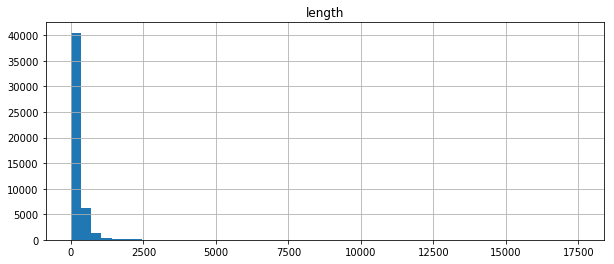

In [14]:
df.hist(bins=50,figsize=(10,4))

In [15]:
max_length = int(df.quantile(0.95)["length"]) #1000
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  665


,length
count,48967.000000
mean,225.796700
std,160.458512
min,7.000000
50%,175.000000
75%,289.000000
80%,329.000000
90%,467.000000
95%,665.000000
max,665.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e0d2550>]],
      dtype=object)

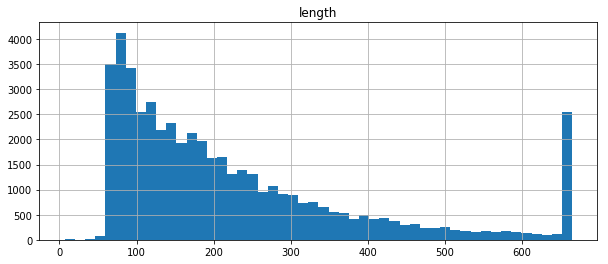

In [16]:
df.hist(bins=50,figsize=(10,4))

In [17]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [18]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [19]:
test_percentage = 0.05

In [20]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 3090
Train/Test split: 46519/2448


<IPython.core.display.Javascript object>

In [21]:
print(x_train.shape)

(46519, 665)


In [22]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [23]:
class RNN:
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size,
                 cell_type, hidden_size, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_text = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_text')
        self.input_y = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        l2_loss = tf.constant(0.0)
        text_length = self._length(self.input_text)

        with tf.device('/cpu:0'), tf.name_scope("text-embedding"):
            self.W_text = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_text")
            self.embedded_chars = tf.nn.embedding_lookup(self.W_text, self.input_text)


        with tf.name_scope("rnn"):
            cell = self._get_cell(hidden_size, cell_type)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=self.dropout_keep_prob)
            all_outputs, _ = tf.nn.dynamic_rnn(cell=cell, inputs=self.embedded_chars, sequence_length=text_length, dtype=tf.float32)
            self.h_outputs = self.last_relevant(all_outputs, text_length)


        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[hidden_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.logits = tf.nn.xw_plus_b(self.h_outputs, W, b, name="logits")
            self.predictions = tf.argmax(self.logits, 1, name="predictions")


        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")

    @staticmethod
    def _get_cell(hidden_size, cell_type):
        if cell_type == "vanilla":
            return tf.nn.rnn_cell.BasicRNNCell(hidden_size)
        elif cell_type == "lstm":
            return tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
        elif cell_type == "gru":
            return tf.nn.rnn_cell.GRUCell(hidden_size)
        else:
            print("ERROR: '" + cell_type + "' is a wrong cell type !!!")
            return None

    @staticmethod
    def _length(seq):
        relevant = tf.sign(tf.abs(seq))
        length = tf.reduce_sum(relevant, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    @staticmethod
    def last_relevant(seq, length):
        batch_size = tf.shape(seq)[0]
        max_length = int(seq.get_shape()[1])
        input_size = int(seq.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(seq, [-1, input_size])
        return tf.gather(flat, index)

In [24]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [25]:
cell_type="lstm"#"vanilla"
word2vec=None
embedding_dim=300
hidden_size=128
dropout_keep_prob=0.5
l2_reg_lambda=3.0

In [28]:
batch_size = 64
display_every=10
num_epochs = 30            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs",cell_type+"_"+level, time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/lstm_char/2018_07_17_21_42_11/



In [ ]:
with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
            allow_soft_placement=allow_soft_placement,
            log_device_placement=log_device_placement)
        
        sess = tf.Session(config=session_conf)
        
        with sess.as_default():
            
            
            rnn = RNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                cell_type=cell_type,
                hidden_size=hidden_size,
                l2_reg_lambda=l2_reg_lambda
            )


            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(learning_rate)
            grads_and_vars = optimizer.compute_gradients(rnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)


            loss_summary = tf.summary.scalar("loss", rnn.loss)
            acc_summary = tf.summary.scalar("accuracy", rnn.accuracy)

            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_dir = os.path.join(out_dir, "summaries", "test")
            test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

            if save_checkpoint:
                checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
                checkpoint_prefix = os.path.join(checkpoint_dir, "model")
                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
            vocab_processor.save(os.path.join(out_dir, "vocab"))


            sess.run(tf.global_variables_initializer())

            # Pre-trained word2vec
            if word2vec:
                # initial matrix with random uniform
                initW = np.random.uniform(-0.25, 0.25, (len(text_vocab_processor.vocabulary_), embedding_dim))
                # load any vectors from the word2vec
                print("Load word2vec file {0}".format(word2vec))
                with open(word2vec, "rb") as f:
                    header = f.readline()
                    vocab_size, layer1_size = map(int, header.split())
                    binary_len = np.dtype('float32').itemsize * layer1_size
                    for line in range(vocab_size):
                        word = []
                        while True:
                            ch = f.read(1).decode('latin-1')
                            if ch == ' ':
                                word = ''.join(word)
                                break
                            if ch != '\n':
                                word.append(ch)
                        idx = text_vocab_processor.vocabulary_.get(word)
                        if idx != 0:
                            initW[idx] = np.fromstring(f.read(binary_len), dtype='float32')
                        else:
                            f.read(binary_len)
                sess.run(rnn.W_text.assign(initW))
                print("Success to load pre-trained word2vec model!\n")


            batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)

            for batch in batches:
                x_batch, y_batch = zip(*batch)
                feed_dict = {
                    rnn.input_text: x_batch,
                    rnn.input_y: y_batch,
                    rnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, rnn.loss, rnn.accuracy], feed_dict)
                train_summary_writer.add_summary(summaries, step)

                if step % display_every == 0:
                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    print("\nEvaluation:")
                    feed_dict_test = {
                        rnn.input_text: x_test,
                        rnn.input_y: y_test,
                        rnn.dropout_keep_prob: 1.0
                    }
                    summaries_test, loss, accuracy = sess.run([test_summary_op, rnn.loss, rnn.accuracy], feed_dict_test)
                    test_summary_writer.add_summary(summaries_test, step)

                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}\n".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=step)
                    print("Saved model checkpoint to {}\n".format(path))

/Users/tdual/anaconda2/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name text-embedding/W_text:0/grad/hist is illegal; using text-embedding/W_text_0/grad/hist instead.
INFO:tensorflow:Summary name text-embedding/W_text:0/grad/sparsity is illegal; using text-embedding/W_text_0/grad/sparsity instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/kernel:0/grad/hist is illegal; using rnn/basic_lstm_cell/kernel_0/grad/hist instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/kernel:0/grad/sparsity is illegal; using rnn/basic_lstm_cell/kernel_0/grad/sparsity instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/bias:0/grad/hist is illegal; using rnn/basic_lstm_cell/bias_0/grad/hist instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/bias:0/grad/sparsity is illegal; using rnn/basic_lstm_cell/bias_0/grad/sparsity instead.
INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.
INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-07-17T21:54:51.282662: step 440, loss 0.330318, acc 0.921875

Evaluation:
2018-07-17T21:55:09.373969: step 440, loss 0.394462, acc 0.879493

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-440

2018-07-17T21:55:19.836262: step 450, loss 0.333209, acc 0.90625
2018-07-17T21:55:29.823451: step 460, loss 0.227683, acc 0.96875

Evaluation:
2018-07-17T21:55:42.599291: step 460, loss 0.396287, acc 0.880719

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-460

2018-07-17T21:55:53.467029: step 470, loss 0.460541, acc 0.84375
2018-07-17T21:56:02.760005: step 480, loss 0.338074, acc 0.921875

Evaluation:
2018-07-17T21:56:14.677688: step 480, loss 0.379044, acc 0.882761

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-480

2018-07-17T21:56:23.344256: step 490, loss 0.373625, acc 0.875
2018

2018-07-17T22:07:28.593350: step 930, loss 0.239723, acc 0.953125
2018-07-17T22:07:36.428415: step 940, loss 0.442918, acc 0.765625

Evaluation:
2018-07-17T22:07:47.264189: step 940, loss 0.383567, acc 0.830474

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-940

2018-07-17T22:07:55.106063: step 950, loss 0.24028, acc 0.9375
2018-07-17T22:08:02.565308: step 960, loss 0.28704, acc 0.9375

Evaluation:
2018-07-17T22:08:13.583031: step 960, loss 0.323189, acc 0.901144

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-960

2018-07-17T22:08:21.175935: step 970, loss 0.323792, acc 0.875
2018-07-17T22:08:28.437003: step 980, loss 0.359829, acc 0.875

Evaluation:
2018-07-17T22:08:39.226789: step 980, loss 0.320496, acc 0.902778

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-980

2018-07-17

2018-07-17T22:19:16.053155: step 1430, loss 0.247577, acc 0.953125
2018-07-17T22:19:24.115778: step 1440, loss 0.399724, acc 0.875

Evaluation:
2018-07-17T22:19:34.907248: step 1440, loss 0.301001, acc 0.918709

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-1440

2018-07-17T22:19:42.678853: step 1450, loss 0.310876, acc 0.90625
2018-07-17T22:19:50.543802: step 1460, loss 0.290215, acc 0.890625

Evaluation:
2018-07-17T22:20:01.690940: step 1460, loss 0.294679, acc 0.915441

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-1460

2018-07-17T22:20:09.462303: step 1470, loss 0.211145, acc 0.9375
2018-07-17T22:20:17.378324: step 1480, loss 0.156599, acc 0.984375

Evaluation:
2018-07-17T22:20:28.376200: step 1480, loss 0.295323, acc 0.919526

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/mode

2018-07-17T22:31:18.323332: step 1920, loss 0.294225, acc 0.911765

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-1920

2018-07-17T22:31:27.775820: step 1930, loss 0.175292, acc 0.96875
2018-07-17T22:31:38.064759: step 1940, loss 0.414263, acc 0.859375

Evaluation:
2018-07-17T22:31:50.567129: step 1940, loss 0.290236, acc 0.917075

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-1940

2018-07-17T22:32:00.134038: step 1950, loss 0.274441, acc 0.9375
2018-07-17T22:32:08.526944: step 1960, loss 0.459019, acc 0.859375

Evaluation:
2018-07-17T22:32:20.177942: step 1960, loss 0.286675, acc 0.914216

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-1960

2018-07-17T22:32:28.256519: step 1970, loss 0.315636, acc 0.875
2018-07-17T22:32:36.446062: step 1980, loss 0.240093, acc 0.9375

Evalua

2018-07-17T22:43:32.137390: step 2410, loss 0.252623, acc 0.9375
2018-07-17T22:43:41.123915: step 2420, loss 0.166888, acc 0.984375

Evaluation:
2018-07-17T22:43:53.684640: step 2420, loss 0.284454, acc 0.927288

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-2420

2018-07-17T22:44:02.950883: step 2430, loss 0.196374, acc 0.953125
2018-07-17T22:44:12.560322: step 2440, loss 0.327874, acc 0.859375

Evaluation:
2018-07-17T22:44:27.303512: step 2440, loss 0.283923, acc 0.921569

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-2440

2018-07-17T22:44:41.138255: step 2450, loss 0.262141, acc 0.953125
2018-07-17T22:44:55.640381: step 2460, loss 0.397127, acc 0.859375

Evaluation:
2018-07-17T22:45:15.985402: step 2460, loss 0.280153, acc 0.92402

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/m

2018-07-17T22:56:21.246754: step 2900, loss 0.306096, acc 0.91299

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-2900

2018-07-17T22:56:28.501281: step 2910, loss 0.38972, acc 0.90625
2018-07-17T22:56:35.664992: step 2920, loss 0.258245, acc 0.9375

Evaluation:
2018-07-17T22:56:46.382489: step 2920, loss 0.28753, acc 0.921569

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-2920

2018-07-17T22:56:53.825780: step 2930, loss 0.184012, acc 0.96875
2018-07-17T22:57:01.145505: step 2940, loss 0.169759, acc 0.984375

Evaluation:
2018-07-17T22:57:12.005729: step 2940, loss 0.281227, acc 0.927288

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-2940

2018-07-17T22:57:19.382112: step 2950, loss 0.242964, acc 0.953125
2018-07-17T22:57:26.469902: step 2960, loss 0.193192, acc 0.953125

Evalu

2018-07-17T23:06:46.745254: step 3390, loss 0.282415, acc 0.9375
2018-07-17T23:06:54.042442: step 3400, loss 0.280187, acc 0.875

Evaluation:
2018-07-17T23:07:04.863521: step 3400, loss 0.284732, acc 0.920343

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-3400

2018-07-17T23:07:12.282676: step 3410, loss 0.306946, acc 0.890625
2018-07-17T23:07:19.687612: step 3420, loss 0.225658, acc 0.953125

Evaluation:
2018-07-17T23:07:30.639513: step 3420, loss 0.279836, acc 0.926471

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-3420

2018-07-17T23:07:37.986714: step 3430, loss 0.233797, acc 0.953125
2018-07-17T23:07:45.328103: step 3440, loss 0.287442, acc 0.9375

Evaluation:
2018-07-17T23:07:56.326729: step 3440, loss 0.277661, acc 0.926879

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model

2018-07-17T23:18:08.823147: step 3890, loss 0.202365, acc 0.96875
2018-07-17T23:18:16.879540: step 3900, loss 0.234255, acc 0.96875

Evaluation:
2018-07-17T23:18:28.317087: step 3900, loss 0.268332, acc 0.929739

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-3900

2018-07-17T23:18:36.540480: step 3910, loss 0.338567, acc 0.90625
2018-07-17T23:18:44.907470: step 3920, loss 0.250909, acc 0.9375

Evaluation:
2018-07-17T23:18:56.181718: step 3920, loss 0.261086, acc 0.932598

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-3920

2018-07-17T23:19:04.062361: step 3930, loss 0.214432, acc 0.96875
2018-07-17T23:19:12.040431: step 3940, loss 0.2036, acc 0.953125

Evaluation:
2018-07-17T23:19:23.286325: step 3940, loss 0.260872, acc 0.936275

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-

2018-07-17T23:30:44.561713: step 4390, loss 0.311357, acc 0.9375
2018-07-17T23:30:54.873977: step 4400, loss 0.133249, acc 1

Evaluation:
2018-07-17T23:31:09.645298: step 4400, loss 0.262147, acc 0.935866

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-4400

2018-07-17T23:31:21.940898: step 4410, loss 0.225276, acc 0.953125
2018-07-17T23:31:34.872524: step 4420, loss 0.182514, acc 0.984375

Evaluation:
2018-07-17T23:31:53.771657: step 4420, loss 0.269241, acc 0.933415

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-4420

2018-07-17T23:32:06.438863: step 4430, loss 0.233014, acc 0.953125
2018-07-17T23:32:18.165165: step 4440, loss 0.2195, acc 0.96875

Evaluation:
2018-07-17T23:32:33.594591: step 4440, loss 0.263422, acc 0.932598

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-4440

2018-07-17T23:49:13.886865: step 4890, loss 0.206323, acc 0.953125
2018-07-17T23:49:23.319021: step 4900, loss 0.250789, acc 0.953125

Evaluation:
2018-07-17T23:49:36.380591: step 4900, loss 0.256886, acc 0.938725

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-4900

2018-07-17T23:49:46.516924: step 4910, loss 0.247263, acc 0.9375
2018-07-17T23:49:56.686315: step 4920, loss 0.261088, acc 0.9375

Evaluation:
2018-07-17T23:50:09.471933: step 4920, loss 0.263009, acc 0.93219

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-4920

2018-07-17T23:50:18.956381: step 4930, loss 0.208728, acc 0.96875
2018-07-17T23:50:28.208457: step 4940, loss 0.217657, acc 0.9375

Evaluation:
2018-07-17T23:50:41.120486: step 4940, loss 0.259972, acc 0.935458

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-

2018-07-18T00:02:53.298650: step 5380, loss 0.260009, acc 0.935866

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-5380

2018-07-18T00:03:03.464398: step 5390, loss 0.195165, acc 0.953125
2018-07-18T00:03:13.664743: step 5400, loss 0.232848, acc 0.90625

Evaluation:
2018-07-18T00:03:26.911698: step 5400, loss 0.256534, acc 0.940359

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-5400

2018-07-18T00:03:36.956214: step 5410, loss 0.255507, acc 0.953125
2018-07-18T00:03:47.052247: step 5420, loss 0.217613, acc 0.984375

Evaluation:
2018-07-18T00:04:00.454960: step 5420, loss 0.285948, acc 0.921977

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-5420

2018-07-18T00:04:11.227353: step 5430, loss 0.255759, acc 0.953125
2018-07-18T00:04:22.011175: step 5440, loss 0.28613, acc 0.9375

Ev

2018-07-18T00:17:03.167809: step 5870, loss 0.243391, acc 0.953125
2018-07-18T00:17:13.341193: step 5880, loss 0.220573, acc 0.96875

Evaluation:
2018-07-18T00:17:26.285509: step 5880, loss 0.26988, acc 0.933007

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-5880

2018-07-18T00:17:35.929568: step 5890, loss 0.202694, acc 0.953125
2018-07-18T00:17:46.142983: step 5900, loss 0.29949, acc 0.890625

Evaluation:
2018-07-18T00:17:58.963253: step 5900, loss 0.266971, acc 0.935866

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-5900

2018-07-18T00:18:08.691729: step 5910, loss 0.188093, acc 0.984375
2018-07-18T00:18:18.512438: step 5920, loss 0.152667, acc 1

Evaluation:
2018-07-18T00:18:32.840359: step 5920, loss 0.264518, acc 0.936275

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-59

2018-07-18T00:34:13.796280: step 6360, loss 0.256302, acc 0.938725

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-6360

2018-07-18T00:34:25.427086: step 6370, loss 0.17832, acc 0.984375
2018-07-18T00:34:39.179675: step 6380, loss 0.21528, acc 0.96875

Evaluation:
2018-07-18T00:35:00.816833: step 6380, loss 0.25384, acc 0.941176

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-6380

2018-07-18T00:35:16.468986: step 6390, loss 0.179485, acc 0.96875
2018-07-18T00:35:28.755128: step 6400, loss 0.259509, acc 0.9375

Evaluation:
2018-07-18T00:35:45.427441: step 6400, loss 0.253222, acc 0.939542

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-6400

2018-07-18T00:35:58.556293: step 6410, loss 0.149089, acc 0.96875
2018-07-18T00:36:14.614832: step 6420, loss 0.139734, acc 1

Evaluation:
2

2018-07-18T00:51:08.127028: step 6850, loss 0.16249, acc 1
2018-07-18T00:51:19.401217: step 6860, loss 0.244856, acc 0.9375

Evaluation:
2018-07-18T00:51:35.727992: step 6860, loss 0.264066, acc 0.934232

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-6860

2018-07-18T00:51:47.959967: step 6870, loss 0.194124, acc 0.984375
2018-07-18T00:51:59.498407: step 6880, loss 0.193621, acc 0.984375

Evaluation:
2018-07-18T00:52:14.719248: step 6880, loss 0.267654, acc 0.936683

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-6880

2018-07-18T00:52:25.929983: step 6890, loss 0.174983, acc 0.984375
2018-07-18T00:52:36.378569: step 6900, loss 0.203816, acc 0.96875

Evaluation:
2018-07-18T00:52:50.519446: step 6900, loss 0.26059, acc 0.938725

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/lstm_char/2018_07_17_21_42_11/checkpoints/model-6900